# Example: Calculating the Scalp Coupling Index

This notebook calculates the Scalp Coupling Index[1] metric for assessing the signal quality of a recording.


[1] [1] L. Pollonini, C. Olds, H. Abaya, H. Bortfeld, M. S. Beauchamp, and J. S. Oghalai, “Auditory cortex activation to natural speech and simulated cochlear implant speech measured with functional near-infrared spectroscopy,” Hearing Research, vol. 309, pp. 84–93, Mar. 2014, doi: 10.1016/j.heares.2013.11.007.


In [1]:
import cedalion
import cedalion.nirs
import cedalion.xrutils as xrutils
import numpy as np
import xarray as xr
import pint
import matplotlib.pyplot as p
import scipy.signal
import os.path

### Loading raw CW-NIRS data from a SNIRF file

This notebook uses a finger-tapping dataset in BIDS layout provided by Rob Luke. Download it [here](https://github.com/rob-luke/BIDS-NIRS-Tapping) and point the variable `DATADIR` to its location.

In [2]:
DATADIR = "../../data/BIDS-NIRS-Tapping"

In [3]:
subjects  = [f"sub-{i:02d}" for i in [1,2,3,4,5]]

# store data of different subjects in a dictionary
data = {} 
for subject in subjects:
    
    elements = cedalion.io.read_snirf(
        os.path.join(DATADIR, f"{subject}/nirs/{subject}_task-tapping_nirs.snirf")
    )

    amp = elements[0].data[0]

    amp = amp.pint.dequantify().pint.quantify("volts") # work around missing units in snirf file

    stim = elements[0].stim # pandas Dataframe
    geo3d = elements[0].geo3d
    
    # cedalion registers an accessor (attribute .cd ) on pandas DataFrames
    stim.cd.rename_events( {
        "1.0" : "control",
        "2.0" : "Tapping/Left",
        "3.0" : "Tapping/Right"
    })
    
    dpf = xr.DataArray([6, 6], dims="wavelength", coords={"wavelength" : amp.wavelength})
    
    data[subject] = xr.Dataset(
        data_vars = {
            "amp" : amp,
            "geo" : geo3d,
        },
        attrs={"stim" : stim}, # store stimulus data in attrs
        coords={"subject" : subject} # add the subject label as a coordinate
    )

In [4]:
data["sub-01"]

Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0941083 0.0940129 0.0944882] [0.1856806 0.186377 0.1836514 ... 0.1856486 0.1850836 0.1842172]] [[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] ... [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]] [[0.4885007 0.4802285 0.4818338 ... 0.6109142 0.6108118 0.613845] [0.8457658 0.825988 0.8259648 ... 0.975894 0.9756599 0.9826459]] [[0.6304559 0.6284427 0.6287045 ... 0.6810626 0.6809573 0.6818709] [1.2285622 1.2205907 1.2190002 ... 1.2729124 1.2727222 1.2755645]]]
Units,volt
Magnitude,[[-0.041613204679326624 0.026799775287857947 0.1299043936308115] [-0.06476686499872276 0.05814256998996063 0.0908425773727145] [-0.07120554551675068 -0.012874272652217859 0.10787860947691345] [-0.0859043654400404 0.018971698468891116 0.06509762433137256] [0.03694171596700852 0.02748380530252158 0.13022129709104263] [0.06065133742692848 0.05882414589197514 0.09117717995727878] [0.06712771392323756 -0.012199231886346213 0.1085725493643022] [0.08188685574250908 0.020427932162352107 0.06571325110115192] [-0.037619588707178915 0.06322851630256272 0.11572802770110814] [-0.04134445059646741 -0.011779611291995052 0.13495002938154654] [-0.07242424650162711 0.02347293206381116 0.10322218957482163] [-0.07912592748234686 0.05140929117919257 0.057370046083468226] [0.03352717285472944 0.06359968341212022 0.11583881331702946] [0.03686639505686032 -0.011397164907962862 0.13536724076864515] [0.06791592703520163 0.02468254467119271 0.10366605207860985] [0.075310088095807 0.05226884499005337 0.05787698428594235] [-0.03773895423262196 0.034082658086024245 0.1294919790818403] [-0.061454307897075164 0.06443800208211416 0.09061004226260877] [-0.07282878975853647 -0.00527870527992114 0.10743054838539287] [-0.08439610638498087 0.02706123378098264 0.06559510739262155] [0.040013338219712126 0.020439745814301982 0.13063767506528579] [0.06428020193514211 0.05162125732852231 0.09133632943784001] [0.06521393141744246 -0.019260368037897515 0.10880928230870081] [0.08272091030272573 0.012990608473329186 0.06658402323335233] [-0.0824899918305801 3.5272652784690273e-09 -8.985265795291575e-10] [6.534060185275914e-12 0.11404663614484922 -8.956669156345853e-09] [0.08248999697928468 3.893090638057428e-09 4.766247813092761e-10] [-0.04018770669918394 0.044642295725887106 0.12357659157001165] [-0.04174110787598461 0.007685839199884737 0.13437743644514044] [-0.05885642692737942 0.026136335712672674 0.11745327806321545] [0.03851939726517181 0.03078283979366837 0.1281798987708399] [-0.052808259274512416 0.06188780045911764 0.10403189889709587] [-0.06922421433143165 0.04108974212744533 0.0972095427514579] [-0.07351067792317667 0.05556043944468993 0.07592438053279707] [0.031418413207589764 0.05609701242391968 0.12112072355182572] [-0.05798909959739463 -0.013176608236818512 0.12293491786782985] [-0.07419549041066105 0.00549319711704184 0.10669158774707252] [0.023828589288117673 0.003996293896988853 0.14081960191362605] [-0.08184195746940305 0.022098763709400317 0.08422485645365857] [-0.08309090979477994 0.03520830182778492 0.0610323268526085] [0.026425335781627597 0.043375220063173334 0.12939415639453739] [0.035781770725957916 0.04568049698512951 0.12354633505671649] [0.037556277679295876 0.008001190852073497 0.134555406719549] [0.054080633753515184 0.026705026363902817 0.11818464121484251] [0.06801076312164317 0.02284818084680601 0.10445872040876931] [0.0481712114118228 0.062034828924799924 0.10518292837437133] [0.06461419274656584 0.042329086589563227 0.0977770136200937] [0.06967032405092426 0.05604290375898291 0.07590918892077606] [0.07526945345643418 0.037578919664336574 0.08007431341875021] [0.05288202968424921 -0.012139614237985343 0.12430811820847815]

## Calculating the SCI

From the paper:

> Since the LED sources at 760 nm and 850 nm were co-located, an optical channel in good contact with the scalp exhibited a prominent synchronous cardiac pulsation in both photodetected signals. This observation was independent of the
> amplitude of the output voltage of the photodetector, which in turn depends on the inter-distance between sources and detector. For each channel, we filtered both photodetected signals between 0.5 and 2.5 Hz to preserve only the cardiac
> component and normalized the resulting signals to balance any difference between their amplitude. Then, we computed the cross-correlation and we extracted the value at a time lag of 0 to quantify the similarity between the filtered 
> signals. In-phase and counter-phase identical waveforms yielded a zero-lag cross-correlation value of 1 and +1 respectively, whereas a null value derived from totally uncorrelated signals. Therefore, the zero-lag cross-correlation
> between photodetected signals of the same channel was used as a quantitative measure of the signal-to-noise ratio of the channel. We termed this value the scalp coupling index (SCI).


### 0. Utilities

In [5]:
def plot_channel(array, channel, ylabel, xlabel="time", tmin=1000, tmax=1030):
    f, ax = p.subplots(1,1, figsize=(12,4))
    ax.plot(array.time, array.sel(channel=channel, wavelength=760), "r-")
    ax.plot(array.time, array.sel(channel=channel, wavelength=850), "b-")
    p.xlim(tmin, tmax)
    p.xlabel(xlabel)
    p.ylabel(ylabel)

### 1. Bandpass filter to extract the cardiac signal

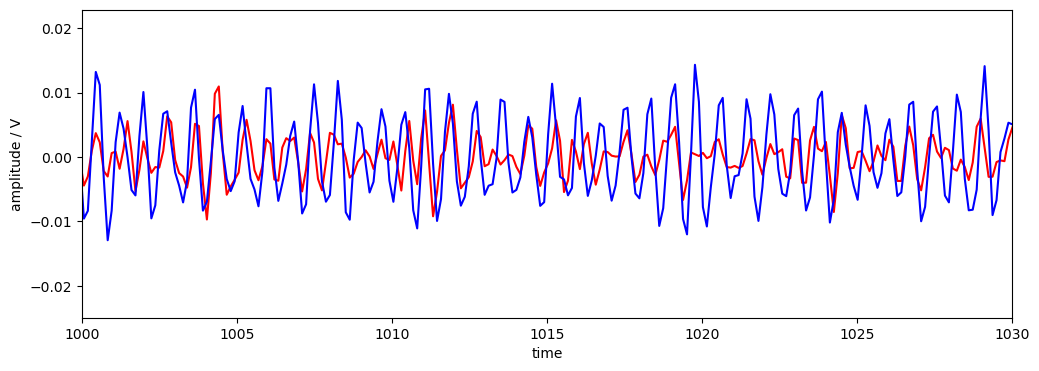

In [6]:
amp = data["sub-01"]["amp"]
amp_filtered = amp.cd.freq_filter(0.5, 2.5, butter_order=4)

plot_channel(amp_filtered, "S5D7", "amplitude / V")


### 2. Normalize filtered amplitudes

Subtract the mean and normalize to each channels standard deviation.

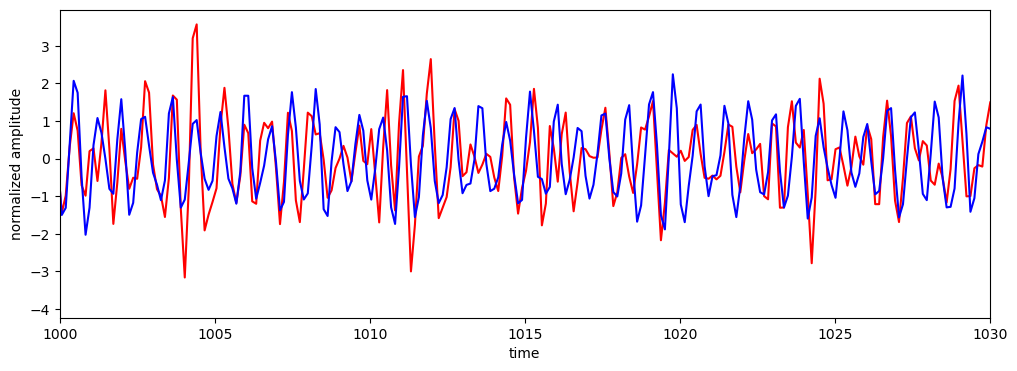

In [7]:
amp_filtered_normed = (amp_filtered - amp_filtered.mean("time")) / amp_filtered.std("time")

plot_channel(amp_filtered_normed, "S5D7", "normalized amplitude")

### 3. Moving window

In [10]:
window_len_s = 2 # seconds
window_len_samples = int(np.ceil(window_len_s * amp_filtered_normed.cd.sampling_rate))
print(window_len_samples)

16
